In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

In [52]:
# flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [53]:
flights.head()

,MissionDate,R-T,PULOC,DropLoc,Deportees
0,2010-10-01,T,KDEN,KIWA,3
1,2010-10-01,T,KMCI,KAEX,6
2,2010-10-01,T,KMDT,KAEX,18
3,2010-10-01,T,KOAK,KIWA,2
4,2010-10-01,T,KOAK,KSAN,3


In [54]:
# flights['pickup_airport'] = flights['pickup_airport'].str.upper()
# flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
flights['pickup_airport'] = flights['PULOC'].str.upper()
flights['dropoff_airport'] = flights['DropLoc'].str.upper()

In [55]:
flights_loc = set(pd.concat([flights['pickup_airport'], flights['dropoff_airport']]))

In [56]:
bad_airports = ['KKBL']

In [57]:
flights = flights[~flights['pickup_airport'].isin(bad_airports)]
flights = flights[~flights['dropoff_airport'].isin(bad_airports)]

In [58]:
airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [59]:
airports.head()

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDirection,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726


In [60]:
airports_loc = set(airports['ICAOCode'])

In [61]:
airports.set_index('ICAOCode', inplace=True)

In [62]:
additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [63]:
additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
additional_airports.set_index('ICAOCode', inplace=True)
additional_airports.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [64]:
missing_airports = list(flights_loc.difference(airports_loc))

In [65]:
missing_airports

['KTOL', 'KPSM', 'KNYL', 'KTWF', 'KGYY', 'KIWA', 'KCSG', 'KLAW', 'KRFD']

In [66]:
airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [67]:
airports_2.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
KCSG,US,GA,Columbus,32.516333,-84.938861
KGYY,US,IN,Gary,41.616389,-87.412778
KIWA,US,AZ,Phoenix,33.307833,-111.655472
KLAW,US,OK,Lawton,34.567778,-98.416389
KNYL,US,AZ,Yuma,32.656667,-114.606111


In [68]:
airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [69]:
airports = pd.concat([airports, airports_2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [70]:
airports

,AirportName,Altitude,City,Country,IATACode,LatitudeDecimalDegrees,LatitudeDegrees,LatitudeDirection,LatitudeMinutes,LatitudeSeconds,LongitudeDecimalDegrees,LongitudeDegrees,LongitudeDirection,LongitudeMinutes,LongitudeSeconds
ICAOCode,,,,,,,,,,,,,,,
AYGA,GOROKA,1610.0,GOROKA,PAPUA NEW GUINEA,GKA,-6.082000,6.0,S,4.0,54.0,145.392000,145.0,E,23.0,30.0
AYLA,NaN,0.0,LAE,PAPUA NEW GUINEA,LAE,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0
AYMD,MADANG,7.0,MADANG,PAPUA NEW GUINEA,MAG,-5.207000,5.0,S,12.0,25.0,145.789000,145.0,E,47.0,19.0
AYMH,MOUNT HAGEN,1643.0,MOUNT HAGEN,PAPUA NEW GUINEA,HGU,-5.826000,5.0,S,49.0,34.0,144.296000,144.0,E,17.0,46.0
AYNZ,NADZAB,73.0,NADZAB,PAPUA NEW GUINEA,LAE,-6.570000,6.0,S,34.0,11.0,146.726000,146.0,E,43.0,34.0
AYPY,PORT MORESBY JACKSONS INTERNATIONAL,45.0,PORT MORESBY,PAPUA NEW GUINEA,POM,-9.443000,9.0,S,26.0,36.0,147.220000,147.0,E,13.0,12.0
AYRB,NaN,0.0,RABAUL,PAPUA NEW GUINEA,RAB,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0
AYWK,WEWAK INTERNATIONAL,6.0,WEWAK,PAPUA NEW GUINEA,WWK,-3.584000,3.0,S,35.0,1.0,143.669000,143.0,E,40.0,9.0
BGAM,NaN,0.0,ANGMAGSSALIK,GREENLAND,NaN,0.000000,0.0,U,0.0,0.0,0.000000,0.0,U,0.0,0.0


In [71]:
edges = flights[['pickup_airport', 'dropoff_airport']].values

In [72]:
g = nx.from_edgelist(edges)

In [73]:
len(g.nodes()), len(g.edges())

(73, 299)

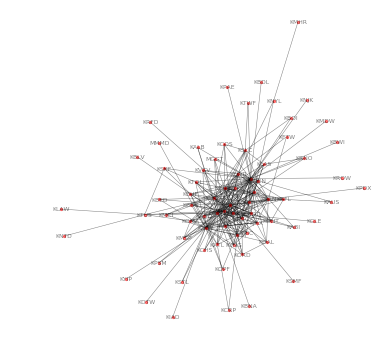

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [75]:
sg = next(nx.connected_component_subgraphs(g))

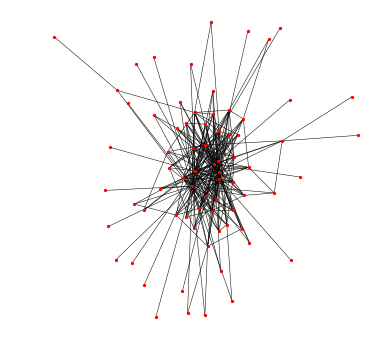

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [77]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airports.to_dict('index').items()}

In [78]:
deg = nx.degree(sg)
sizes = [5 * deg[icao] for icao in sg.nodes]

In [79]:
# altitude = airports_us['alt']
# altitude = [altitude[icao] for icao in sg.nodes]

In [80]:
labels = {icao: icao if deg[icao] >= 20 else ''
          for icao in sg.nodes}

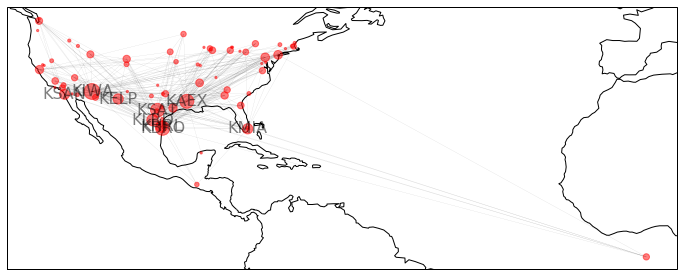

In [81]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
# ax.set_extent([-128, -62, 10, 50])
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.autumn)